In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/markuswiikjensen/Desktop/Master-Data/Final_data/elspot_prices_dt_interpolated.csv')
df.drop(df.loc[df['datetime'].duplicated()].index, inplace = True)
df['datetime'] = pd.to_datetime(df['datetime'])

# df = df.sort_values(df['datetime'], ascending=[True])

last_date = df['datetime'] < '2023-04-01 00:00:00'
df = df[last_date]
df.set_index(df['datetime'], inplace = True)
df.drop(columns = [ 'datetime','Unnamed: 0'], inplace = True)
df

,Oslo,Kr.sand,Bergen,Molde,Tr.heim,TromsÃ¸
datetime,,,,,,
2020-01-01 00:00:00,31386.0,31386.0,31386.0,28387.0,28387.0,28387.0
2020-01-01 01:00:00,31336.0,31336.0,31336.0,28062.0,28062.0,28062.0
2020-01-01 02:00:00,31139.0,31139.0,31139.0,27519.0,27519.0,27519.0
2020-01-01 03:00:00,30853.0,30853.0,30853.0,27144.0,27144.0,27144.0
2020-01-01 04:00:00,30301.0,30301.0,30301.0,27164.0,27164.0,27164.0
...,...,...,...,...,...,...
2023-03-31 19:00:00,118638.0,118638.0,118638.0,74475.0,74475.0,35008.0
2023-03-31 20:00:00,115541.0,115541.0,115541.0,74520.0,74520.0,35008.0
2023-03-31 21:00:00,108281.0,108281.0,108281.0,75882.0,75882.0,35008.0


In [2]:
df1=df['Oslo']
df2=pd.DataFrame()
df2['Pred']=df['Oslo'].shift(24).copy()
data=pd.concat((df1,df2), axis= 1)


In [3]:
data=data.dropna(0)


/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_42548/1309451091.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  data=data.dropna(0)


In [4]:
data

,Oslo,Pred
datetime,,
2020-01-02 00:00:00,30235.0,31386.0
2020-01-02 01:00:00,30097.0,31336.0
2020-01-02 02:00:00,29891.0,31139.0
2020-01-02 03:00:00,29311.0,30853.0
2020-01-02 04:00:00,29370.0,30301.0
...,...,...
2023-03-31 19:00:00,118638.0,116558.0
2023-03-31 20:00:00,115541.0,124299.0
2023-03-31 21:00:00,108281.0,115610.0


MAPE: 81.82%
RMSE: 50595.03
MAE: 29143.12
RSS: 22424349117775


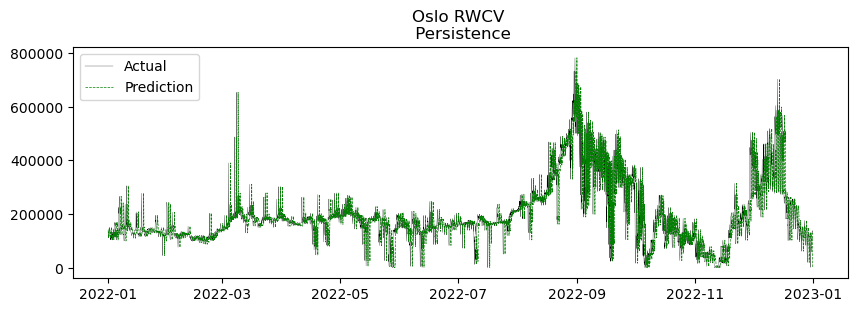

In [6]:
train_set = data[:365*24*2]
val_set = data[365*24*2:365*24*3]


# calculate evaluation metrics
mape = np.mean(np.abs((val_set['Oslo'].values - val_set['Pred'].values) / val_set['Oslo'].values)) * 100
rmse = np.sqrt(mean_squared_error(val_set['Oslo'].values, val_set['Pred'].values))
mae = mean_absolute_error(val_set['Oslo'].values, val_set['Pred'].values)

# compute the residuals
residuals = val_set['Oslo'].values- val_set['Pred'].values

# compute the RSS
rss = np.sum(residuals**2)

print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'RSS: {rss:.0f}')

# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(val_set.index.values, val_set['Oslo'].values, label='Actual', linewidth=0.2,  c='black')
plt.plot(val_set.index.values, val_set['Pred'].values, label='Prediction', linewidth=0.5, linestyle='--', c='g')
plt.title('Oslo RWCV \n Persistence')
plt.legend()
plt.show()


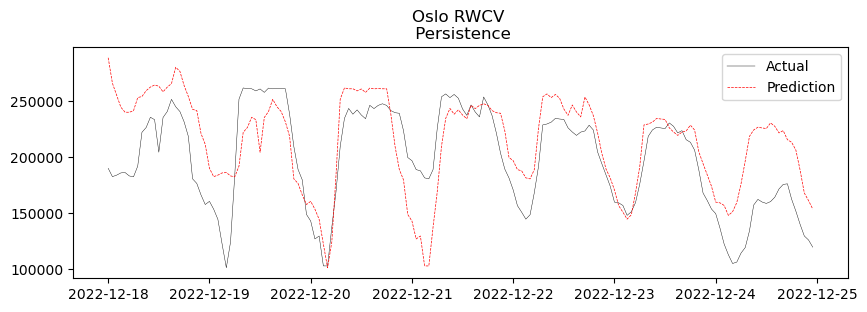

In [7]:
# Define x-axis values
x_pred = np.arange(8760)
x_actual = np.arange(26280)


# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(val_set.index[-24*14:-24*7].values, val_set['Oslo'][-24*14:-24*7].values, label='Actual', linewidth=0.3,  c='black')
plt.plot(val_set.index[-24*14:-24*7].values, val_set['Pred'][-24*14:-24*7].values, label='Prediction', linewidth=0.5, linestyle='--', c='r')
plt.title('Oslo RWCV \n Persistence')
plt.legend()
plt.show()



In [8]:
morning_mask = (val_set.iloc[-365*24:].index.hour >= 6) & (val_set.iloc[-365*24:].index.hour < 12)
midday_mask = (val_set.iloc[-365*24:].index.hour >= 12) & (val_set.iloc[-365*24:].index.hour < 15)
evening_mask = (val_set.iloc[-365*24:].index.hour >= 15) & (val_set.iloc[-365*24:].index.hour < 21)
night_mask = (val_set.iloc[-365*24:].index.hour >= 21) | (val_set.iloc[-365*24:].index.hour < 6)

preds=pd.Series(val_set['Pred'].values, index=val_set.index.values)
actual= pd.Series(val_set['Oslo'].values, index=val_set.index.values)

rmse_morning_scores= np.sqrt(mean_squared_error(actual[morning_mask], preds[morning_mask]))
rmse_morning_scores

rmse_midday_scores= np.sqrt(mean_squared_error(actual[midday_mask], preds[midday_mask]))
rmse_midday_scores

rmse_evening_scores= np.sqrt(mean_squared_error(actual[evening_mask], preds[evening_mask]))
rmse_evening_scores

rmse_night_scores= np.sqrt(mean_squared_error(actual[night_mask], preds[night_mask]))
rmse_night_scores

rmse_scores=pd.Series((rmse_morning_scores,rmse_midday_scores,rmse_evening_scores, rmse_night_scores))


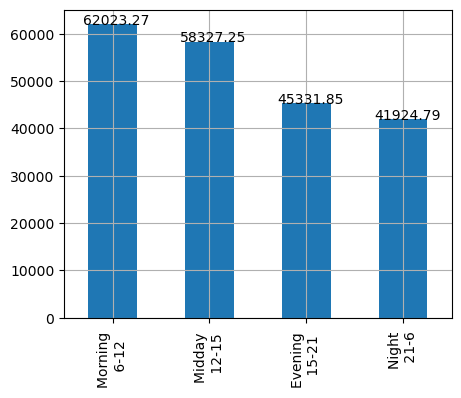

In [9]:
rmse_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(rmse_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))

plt.show()

In [10]:
mape_morning_scores= np.mean(np.abs(actual[morning_mask] -preds[morning_mask]) / actual[morning_mask]) * 100

mape_midday_scores= np.mean(np.abs(actual[midday_mask] -preds[midday_mask]) / actual[midday_mask]) * 100

mape_evening_scores= np.mean(np.abs(actual[evening_mask] -preds[evening_mask]) / actual[evening_mask]) * 100

mape_night_scores= np.mean(np.abs(actual[night_mask] -preds[night_mask]) / actual[night_mask]) * 100


mape_scores=pd.Series((mape_morning_scores,mape_midday_scores,mape_evening_scores, mape_night_scores))


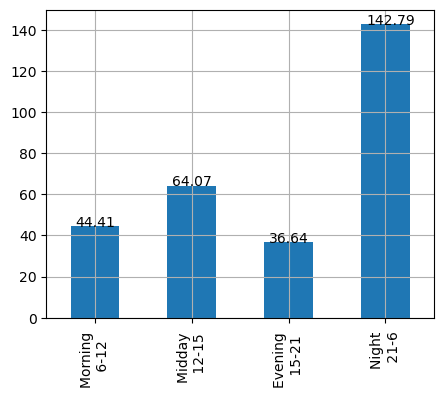

In [11]:
mape_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mape_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.2, v))

plt.show()

In [12]:

mae_morning_scores = mean_absolute_error(actual[morning_mask], preds[morning_mask])
mae_midday_scores = mean_absolute_error(actual[midday_mask], preds[midday_mask])
mae_evening_scores = mean_absolute_error(actual[evening_mask], preds[evening_mask])
mae_night_scores = mean_absolute_error(actual[night_mask], preds[night_mask])

mae_scores = pd.Series((mae_morning_scores, mae_midday_scores, mae_evening_scores, mae_night_scores))


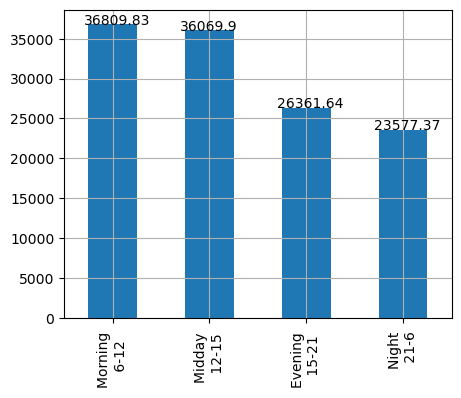

In [13]:
mae_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mae_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))

plt.show()

MAPE: 25.19%
RMSE: 29469.97
MAE: 19946.01
RSS: 1875915370136


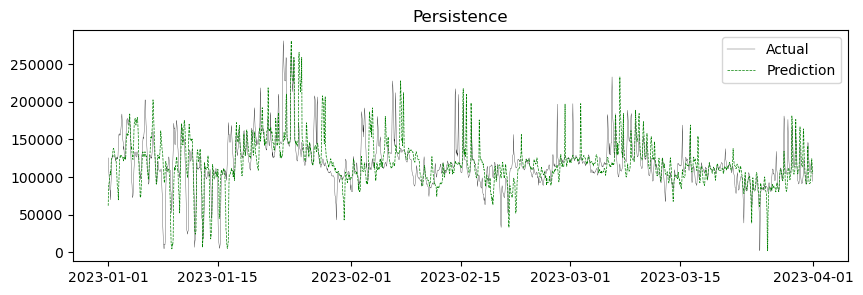

In [14]:
from sklearn.metrics import mean_absolute_error

train_set = data[:365*24*3]
test_set = data[365*24*3:]

# calculate metrics
mape = np.mean(np.abs((test_set['Oslo'].values - test_set['Pred'].values) / test_set['Oslo'].values)) * 100
rmse = np.sqrt(mean_squared_error(test_set['Oslo'].values, test_set['Pred'].values))
mae= mean_absolute_error(test_set['Oslo'].values, test_set['Pred'].values)

# compute the residuals
residuals = test_set['Oslo'].values- test_set['Pred'].values

# compute the RSS
rss = np.sum(residuals**2)

print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'RSS: {rss:.0f}')

# plot the actual and predicted testues
plt.figure(figsize=(10, 3))
plt.plot(test_set.index.values, test_set['Oslo'].values, label='Actual', linewidth=0.2, c='black')
plt.plot(test_set.index.values, test_set['Pred'].values, label='Prediction', linewidth=0.5, linestyle='--', c='g')
plt.title('Persistence')
plt.legend()
plt.show()


In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/markuswiikjensen/Desktop/Master-Data/Final_data/elspot_prices_dt_interpolated.csv')
df.drop(df.loc[df['datetime'].duplicated()].index, inplace = True)
df['datetime'] = pd.to_datetime(df['datetime'])

# df = df.sort_values(df['datetime'], ascending=[True])

last_date = df['datetime'] < '2023-04-01 00:00:00'
df = df[last_date]
df.set_index(df['datetime'], inplace = True)
df.drop(columns = [ 'datetime','Unnamed: 0'], inplace = True)
df

,Oslo,Kr.sand,Bergen,Molde,Tr.heim,TromsÃ¸
datetime,,,,,,
2020-01-01 00:00:00,31386.0,31386.0,31386.0,28387.0,28387.0,28387.0
2020-01-01 01:00:00,31336.0,31336.0,31336.0,28062.0,28062.0,28062.0
2020-01-01 02:00:00,31139.0,31139.0,31139.0,27519.0,27519.0,27519.0
2020-01-01 03:00:00,30853.0,30853.0,30853.0,27144.0,27144.0,27144.0
2020-01-01 04:00:00,30301.0,30301.0,30301.0,27164.0,27164.0,27164.0
...,...,...,...,...,...,...
2023-03-31 19:00:00,118638.0,118638.0,118638.0,74475.0,74475.0,35008.0
2023-03-31 20:00:00,115541.0,115541.0,115541.0,74520.0,74520.0,35008.0
2023-03-31 21:00:00,108281.0,108281.0,108281.0,75882.0,75882.0,35008.0


In [16]:
from sklearn.metrics import mean_squared_error

In [17]:
df1=df['Kr.sand']
df2=pd.DataFrame()
df2['Pred']=df['Kr.sand'].shift(24).copy()
data=pd.concat((df1,df2), axis= 1)


In [18]:
data=data.dropna(0)


/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_42548/1309451091.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  data=data.dropna(0)


In [19]:
data

,Kr.sand,Pred
datetime,,
2020-01-02 00:00:00,30235.0,31386.0
2020-01-02 01:00:00,30097.0,31336.0
2020-01-02 02:00:00,29891.0,31139.0
2020-01-02 03:00:00,29311.0,30853.0
2020-01-02 04:00:00,29370.0,30301.0
...,...,...
2023-03-31 19:00:00,118638.0,116558.0
2023-03-31 20:00:00,115541.0,124299.0
2023-03-31 21:00:00,108281.0,115610.0


MAPE: 85.10%
RMSE: 59768.29
MAE: 35868.07
RSS: 31292899653837


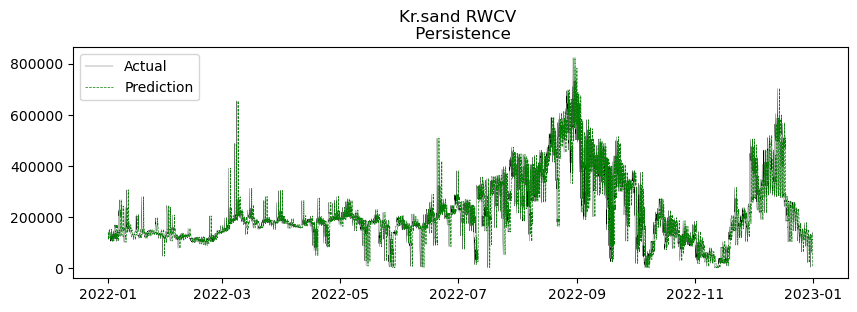

In [21]:
train_set = data[:365*24*2]
val_set = data[365*24*2:365*24*3]


# calculate evaluation metrics
mape = np.mean(np.abs((val_set['Kr.sand'].values - val_set['Pred'].values) / val_set['Kr.sand'].values)) * 100
rmse = np.sqrt(mean_squared_error(val_set['Kr.sand'].values, val_set['Pred'].values))
mae = mean_absolute_error(val_set['Kr.sand'].values, val_set['Pred'].values)
# compute the residuals
residuals = val_set['Kr.sand'].values- val_set['Pred'].values

# compute the RSS
rss = np.sum(residuals**2)

print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'RSS: {rss:.0f}')

# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(val_set.index.values, val_set['Kr.sand'].values, label='Actual', linewidth=0.2,  c='black')
plt.plot(val_set.index.values, val_set['Pred'].values, label='Prediction', linewidth=0.5, linestyle='--', c='g')
plt.title('Kr.sand RWCV \n Persistence')
plt.legend()
plt.show()


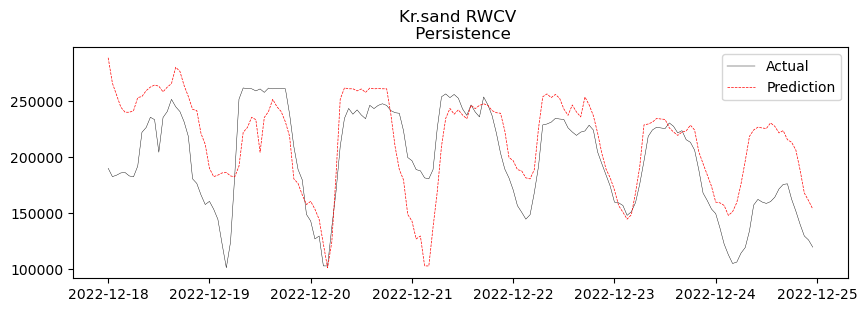

In [22]:
# Define x-axis values
x_pred = np.arange(8760)
x_actual = np.arange(26280)


# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(val_set.index[-24*14:-24*7].values, val_set['Kr.sand'][-24*14:-24*7].values, label='Actual', linewidth=0.3,  c='black')
plt.plot(val_set.index[-24*14:-24*7].values, val_set['Pred'][-24*14:-24*7].values, label='Prediction', linewidth=0.5, linestyle='--', c='r')
plt.title('Kr.sand RWCV \n Persistence')
plt.legend()
plt.show()



In [23]:
morning_mask = (val_set.iloc[-365*24:].index.hour >= 6) & (val_set.iloc[-365*24:].index.hour < 12)
midday_mask = (val_set.iloc[-365*24:].index.hour >= 12) & (val_set.iloc[-365*24:].index.hour < 15)
evening_mask = (val_set.iloc[-365*24:].index.hour >= 15) & (val_set.iloc[-365*24:].index.hour < 21)
night_mask = (val_set.iloc[-365*24:].index.hour >= 21) | (val_set.iloc[-365*24:].index.hour < 6)

preds=pd.Series(val_set['Pred'].values, index=val_set.index.values)
actual= pd.Series(val_set['Kr.sand'].values, index=val_set.index.values)

rmse_morning_scores= np.sqrt(mean_squared_error(actual[morning_mask], preds[morning_mask]))
rmse_morning_scores

rmse_midday_scores= np.sqrt(mean_squared_error(actual[midday_mask], preds[midday_mask]))
rmse_midday_scores

rmse_evening_scores= np.sqrt(mean_squared_error(actual[evening_mask], preds[evening_mask]))
rmse_evening_scores

rmse_night_scores= np.sqrt(mean_squared_error(actual[night_mask], preds[night_mask]))
rmse_night_scores

rmse_scores=pd.Series((rmse_morning_scores,rmse_midday_scores,rmse_evening_scores, rmse_night_scores))


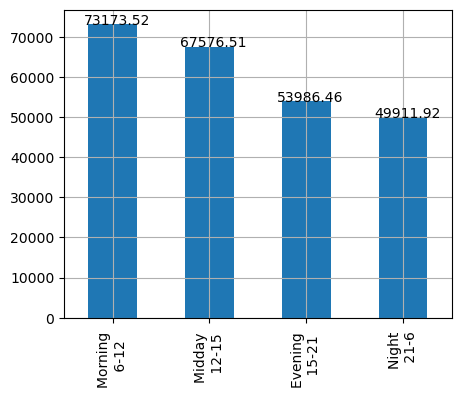

In [24]:
rmse_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(rmse_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))

plt.show()

In [25]:
mape_morning_scores= np.mean(np.abs(actual[morning_mask] -preds[morning_mask]) / actual[morning_mask]) * 100

mape_midday_scores= np.mean(np.abs(actual[midday_mask] -preds[midday_mask]) / actual[midday_mask]) * 100

mape_evening_scores= np.mean(np.abs(actual[evening_mask] -preds[evening_mask]) / actual[evening_mask]) * 100

mape_night_scores= np.mean(np.abs(actual[night_mask] -preds[night_mask]) / actual[night_mask]) * 100


mape_scores=pd.Series((mape_morning_scores,mape_midday_scores,mape_evening_scores, mape_night_scores))


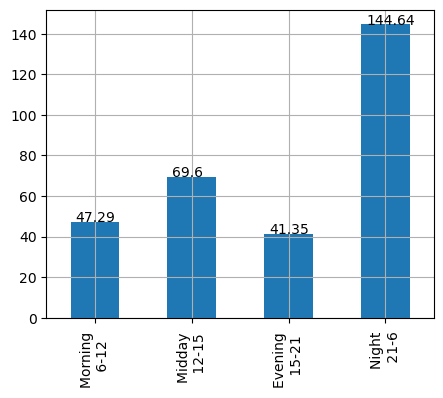

In [26]:
mape_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mape_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.2, v))

plt.show()

In [27]:
from sklearn.metrics import mean_absolute_error
mae_morning_scores = mean_absolute_error(actual[morning_mask], preds[morning_mask])
mae_midday_scores = mean_absolute_error(actual[midday_mask], preds[midday_mask])
mae_evening_scores = mean_absolute_error(actual[evening_mask], preds[evening_mask])
mae_night_scores = mean_absolute_error(actual[night_mask], preds[night_mask])

mae_scores = pd.Series((mae_morning_scores, mae_midday_scores, mae_evening_scores, mae_night_scores))


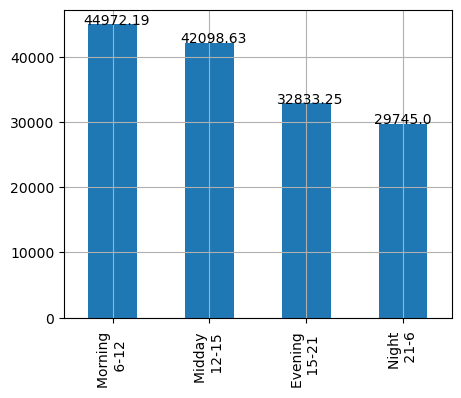

In [28]:
mae_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mae_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))

plt.show()

MAPE: 25.19%
RMSE: 29474.13
MAE: 19943.62
RSS: 1876445092082


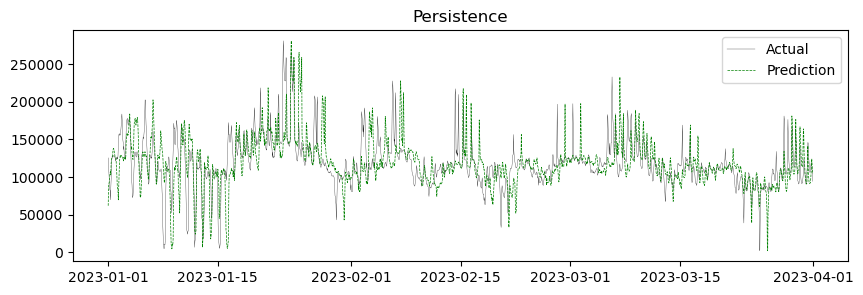

In [29]:
train_set = data[:365*24*3]
test_set = data[365*24*3:]

# calculate metrics
mape = np.mean(np.abs((test_set['Kr.sand'].values - test_set['Pred'].values) / test_set['Kr.sand'].values)) * 100
rmse = np.sqrt(mean_squared_error(test_set['Kr.sand'].values, test_set['Pred'].values))
mae= mean_absolute_error(test_set['Kr.sand'].values, test_set['Pred'].values)

# compute the residuals
residuals = test_set['Kr.sand'].values- test_set['Pred'].values

# compute the RSS
rss = np.sum(residuals**2)

print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'RSS: {rss:.0f}')
# plot the actual and predicted testues
plt.figure(figsize=(10, 3))
plt.plot(test_set.index.values, test_set['Kr.sand'].values, label='Actual', linewidth=0.2, c='black')
plt.plot(test_set.index.values, test_set['Pred'].values, label='Prediction', linewidth=0.5, linestyle='--', c='g')
plt.title('Persistence')
plt.legend()
plt.show()


In [30]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/markuswiikjensen/Desktop/Master-Data/Final_data/elspot_prices_dt_interpolated.csv')
df.drop(df.loc[df['datetime'].duplicated()].index, inplace = True)
df['datetime'] = pd.to_datetime(df['datetime'])

# df = df.sort_values(df['datetime'], ascending=[True])

last_date = df['datetime'] < '2023-04-01 00:00:00'
df = df[last_date]
df.set_index(df['datetime'], inplace = True)
df.drop(columns = [ 'datetime','Unnamed: 0'], inplace = True)
df

,Oslo,Kr.sand,Bergen,Molde,Tr.heim,TromsÃ¸
datetime,,,,,,
2020-01-01 00:00:00,31386.0,31386.0,31386.0,28387.0,28387.0,28387.0
2020-01-01 01:00:00,31336.0,31336.0,31336.0,28062.0,28062.0,28062.0
2020-01-01 02:00:00,31139.0,31139.0,31139.0,27519.0,27519.0,27519.0
2020-01-01 03:00:00,30853.0,30853.0,30853.0,27144.0,27144.0,27144.0
2020-01-01 04:00:00,30301.0,30301.0,30301.0,27164.0,27164.0,27164.0
...,...,...,...,...,...,...
2023-03-31 19:00:00,118638.0,118638.0,118638.0,74475.0,74475.0,35008.0
2023-03-31 20:00:00,115541.0,115541.0,115541.0,74520.0,74520.0,35008.0
2023-03-31 21:00:00,108281.0,108281.0,108281.0,75882.0,75882.0,35008.0


In [31]:
from sklearn.metrics import mean_squared_error

In [37]:
df1=df['Molde']
df2=pd.DataFrame()
df2['Pred']=df['Molde'].shift(24).copy()
data=pd.concat((df1,df2), axis= 1)


In [38]:
data=data.dropna(0)


/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_42548/1309451091.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  data=data.dropna(0)


In [39]:
data

,Molde,Pred
datetime,,
2020-01-02 00:00:00,11856.0,28387.0
2020-01-02 01:00:00,12897.0,28062.0
2020-01-02 02:00:00,18732.0,27519.0
2020-01-02 03:00:00,20746.0,27144.0
2020-01-02 04:00:00,23860.0,27164.0
...,...,...
2023-03-31 19:00:00,74475.0,55870.0
2023-03-31 20:00:00,74520.0,55192.0
2023-03-31 21:00:00,75882.0,54267.0


MAPE: inf%
RMSE: 44054.50
MAE: 17969.56
RSS: 17001401587769


/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_42548/745392926.py:6: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((val_set['Molde'].values - val_set['Pred'].values) / val_set['Molde'].values)) * 100


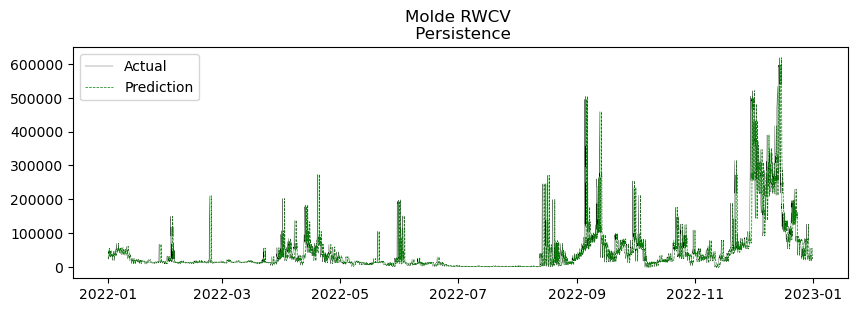

In [41]:
train_set = data[:365*24*2]
val_set = data[365*24*2:365*24*3]


# calculate metrics
mape = np.mean(np.abs((val_set['Molde'].values - val_set['Pred'].values) / val_set['Molde'].values)) * 100
rmse = np.sqrt(mean_squared_error(val_set['Molde'].values, val_set['Pred'].values))
mae= mean_absolute_error(val_set['Molde'].values, val_set['Pred'].values)

# compute the residuals
residuals = val_set['Molde'].values- val_set['Pred'].values

# compute the RSS
rss = np.sum(residuals**2)

print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'RSS: {rss:.0f}')

# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(val_set.index.values, val_set['Molde'].values, label='Actual', linewidth=0.2,  c='black')
plt.plot(val_set.index.values, val_set['Pred'].values, label='Prediction', linewidth=0.5, linestyle='--', c='g')
plt.title('Molde RWCV \n Persistence')
plt.legend()
plt.show()


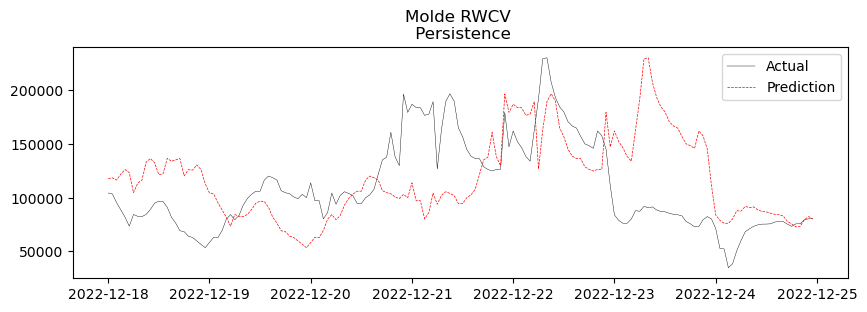

In [42]:
# Define x-axis values
x_pred = np.arange(8760)
x_actual = np.arange(26280)


# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(val_set.index[-24*14:-24*7].values, val_set['Molde'][-24*14:-24*7].values, label='Actual', linewidth=0.3,  c='black')
plt.plot(val_set.index[-24*14:-24*7].values, val_set['Pred'][-24*14:-24*7].values, label='Prediction', linewidth=0.5, linestyle='--', c='r')
plt.title('Molde RWCV \n Persistence')
plt.legend()
plt.show()



In [43]:
morning_mask = (val_set.iloc[-365*24:].index.hour >= 6) & (val_set.iloc[-365*24:].index.hour < 12)
midday_mask = (val_set.iloc[-365*24:].index.hour >= 12) & (val_set.iloc[-365*24:].index.hour < 15)
evening_mask = (val_set.iloc[-365*24:].index.hour >= 15) & (val_set.iloc[-365*24:].index.hour < 21)
night_mask = (val_set.iloc[-365*24:].index.hour >= 21) | (val_set.iloc[-365*24:].index.hour < 6)

preds=pd.Series(val_set['Pred'].values, index=val_set.index.values)
actual= pd.Series(val_set['Molde'].values, index=val_set.index.values)

rmse_morning_scores= np.sqrt(mean_squared_error(actual[morning_mask], preds[morning_mask]))
rmse_morning_scores

rmse_midday_scores= np.sqrt(mean_squared_error(actual[midday_mask], preds[midday_mask]))
rmse_midday_scores

rmse_evening_scores= np.sqrt(mean_squared_error(actual[evening_mask], preds[evening_mask]))
rmse_evening_scores

rmse_night_scores= np.sqrt(mean_squared_error(actual[night_mask], preds[night_mask]))
rmse_night_scores

rmse_scores=pd.Series((rmse_morning_scores,rmse_midday_scores,rmse_evening_scores, rmse_night_scores))


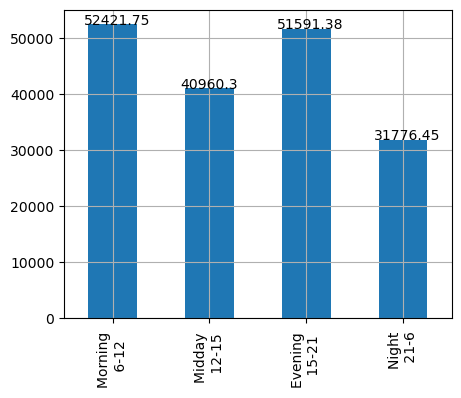

In [44]:
rmse_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(rmse_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))

plt.show()

In [45]:
mape_morning_scores= np.mean(np.abs(actual[morning_mask] -preds[morning_mask]) / actual[morning_mask]) * 100

mape_midday_scores= np.mean(np.abs(actual[midday_mask] -preds[midday_mask]) / actual[midday_mask]) * 100

mape_evening_scores= np.mean(np.abs(actual[evening_mask] -preds[evening_mask]) / actual[evening_mask]) * 100

mape_night_scores= np.mean(np.abs(actual[night_mask] -preds[night_mask]) / actual[night_mask]) * 100


mape_scores=pd.Series((mape_morning_scores,mape_midday_scores,mape_evening_scores, mape_night_scores))


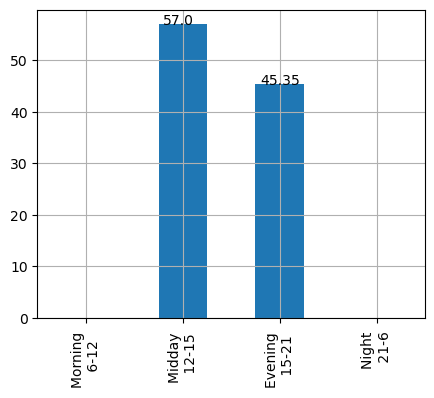

In [46]:
mape_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mape_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.2, v))

plt.show()

In [47]:
from sklearn.metrics import mean_absolute_error
mae_morning_scores = mean_absolute_error(actual[morning_mask], preds[morning_mask])
mae_midday_scores = mean_absolute_error(actual[midday_mask], preds[midday_mask])
mae_evening_scores = mean_absolute_error(actual[evening_mask], preds[evening_mask])
mae_night_scores = mean_absolute_error(actual[night_mask], preds[night_mask])

mae_scores = pd.Series((mae_morning_scores, mae_midday_scores, mae_evening_scores, mae_night_scores))


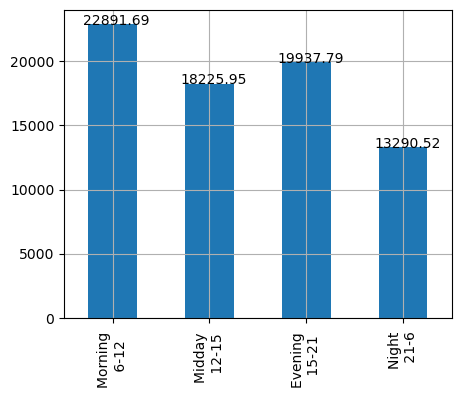

In [48]:
mae_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mae_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))

plt.show()

MAPE: 37.58%
RMSE: 30448.73
MAE: 21069.22
RSS: 2002589934553


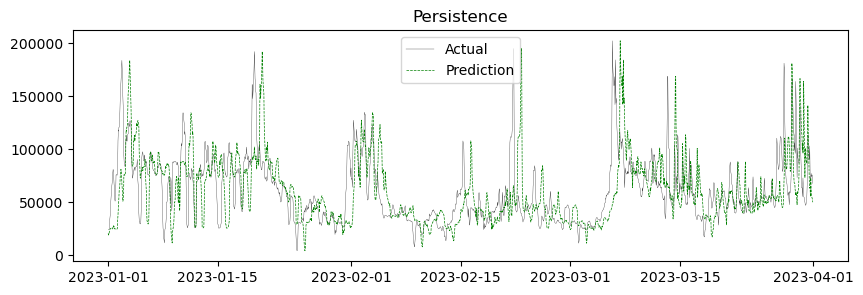

In [50]:
train_set = data[:365*24*3]
test_set = data[365*24*3:]

# calculate metrics
mape = np.mean(np.abs((test_set['Molde'].values - test_set['Pred'].values) / test_set['Molde'].values)) * 100
rmse = np.sqrt(mean_squared_error(test_set['Molde'].values, test_set['Pred'].values))
mae= mean_absolute_error(test_set['Molde'].values, test_set['Pred'].values)

# compute the residuals
residuals =test_set['Molde'].values- test_set['Pred'].values

# compute the RSS
rss = np.sum(residuals**2)

print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'RSS: {rss:.0f}')

# plot the actual and predicted testues
plt.figure(figsize=(10, 3))
plt.plot(test_set.index.values, test_set['Molde'].values, label='Actual', linewidth=0.2, c='black')
plt.plot(test_set.index.values, test_set['Pred'].values, label='Prediction', linewidth=0.5, linestyle='--', c='g')
plt.title('Persistence')
plt.legend()
plt.show()


In [51]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/markuswiikjensen/Desktop/Master-Data/Final_data/elspot_prices_dt_interpolated.csv')
df.drop(df.loc[df['datetime'].duplicated()].index, inplace = True)
df['datetime'] = pd.to_datetime(df['datetime'])

# df = df.sort_values(df['datetime'], ascending=[True])

last_date = df['datetime'] < '2023-04-01 00:00:00'
df = df[last_date]
df.set_index(df['datetime'], inplace = True)
df.drop(columns = [ 'datetime','Unnamed: 0'], inplace = True)
df

,Oslo,Kr.sand,Bergen,Molde,Tr.heim,TromsÃ¸
datetime,,,,,,
2020-01-01 00:00:00,31386.0,31386.0,31386.0,28387.0,28387.0,28387.0
2020-01-01 01:00:00,31336.0,31336.0,31336.0,28062.0,28062.0,28062.0
2020-01-01 02:00:00,31139.0,31139.0,31139.0,27519.0,27519.0,27519.0
2020-01-01 03:00:00,30853.0,30853.0,30853.0,27144.0,27144.0,27144.0
2020-01-01 04:00:00,30301.0,30301.0,30301.0,27164.0,27164.0,27164.0
...,...,...,...,...,...,...
2023-03-31 19:00:00,118638.0,118638.0,118638.0,74475.0,74475.0,35008.0
2023-03-31 20:00:00,115541.0,115541.0,115541.0,74520.0,74520.0,35008.0
2023-03-31 21:00:00,108281.0,108281.0,108281.0,75882.0,75882.0,35008.0


In [52]:
from sklearn.metrics import mean_squared_error

In [53]:
df1=df['TromsÃ¸']
df2=pd.DataFrame()
df2['Pred']=df['TromsÃ¸'].shift(24).copy()
data=pd.concat((df1,df2), axis= 1)


In [54]:
data=data.dropna(0)


/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_42548/1309451091.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  data=data.dropna(0)


In [55]:
data

,TromsÃ¸,Pred
datetime,,
2020-01-02 00:00:00,11856.0,28387.0
2020-01-02 01:00:00,12897.0,28062.0
2020-01-02 02:00:00,18732.0,27519.0
2020-01-02 03:00:00,20746.0,27144.0
2020-01-02 04:00:00,23860.0,27164.0
...,...,...
2023-03-31 19:00:00,35008.0,34463.0
2023-03-31 20:00:00,35008.0,34892.0
2023-03-31 21:00:00,35008.0,34903.0


MAPE: inf%
RMSE: 33532.01
MAE: 9878.56
RSS: 9849705786135


/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_42548/4056278935.py:6: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((val_set['TromsÃ¸'].values - val_set['Pred'].values) / val_set['TromsÃ¸'].values)) * 100


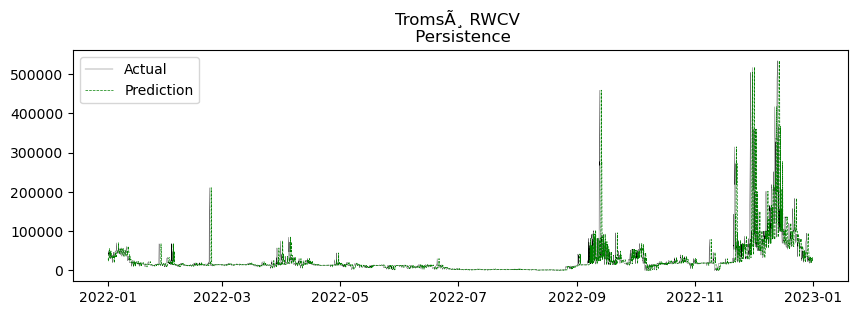

In [57]:
train_set = data[:365*24*2]
val_set = data[365*24*2:365*24*3]


# calculate metrics
mape = np.mean(np.abs((val_set['TromsÃ¸'].values - val_set['Pred'].values) / val_set['TromsÃ¸'].values)) * 100
rmse = np.sqrt(mean_squared_error(val_set['TromsÃ¸'].values, val_set['Pred'].values))
mae= mean_absolute_error(val_set['TromsÃ¸'].values, val_set['Pred'].values)

# compute the residuals
residuals =val_set['TromsÃ¸'].values- val_set['Pred'].values

# compute the RSS
rss = np.sum(residuals**2)

print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'RSS: {rss:.0f}')
# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(val_set.index.values, val_set['TromsÃ¸'].values, label='Actual', linewidth=0.2,  c='black')
plt.plot(val_set.index.values, val_set['Pred'].values, label='Prediction', linewidth=0.5, linestyle='--', c='g')
plt.title('TromsÃ¸ RWCV \n Persistence')
plt.legend()
plt.show()


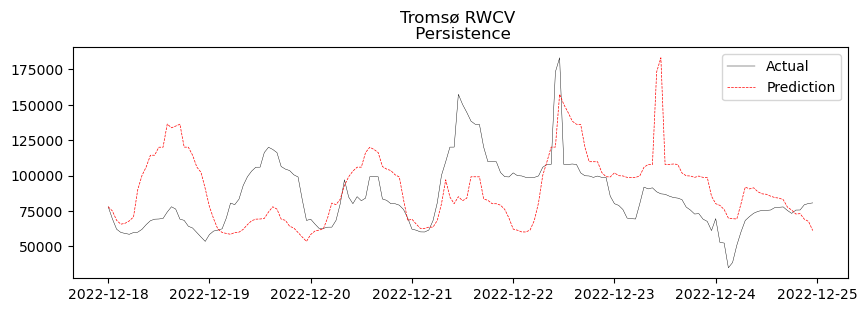

In [58]:
# Define x-axis values
x_pred = np.arange(8760)
x_actual = np.arange(26280)


# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(val_set.index[-24*14:-24*7].values, val_set['TromsÃ¸'][-24*14:-24*7].values, label='Actual', linewidth=0.3,  c='black')
plt.plot(val_set.index[-24*14:-24*7].values, val_set['Pred'][-24*14:-24*7].values, label='Prediction', linewidth=0.5, linestyle='--', c='r')
plt.title('Tromsø RWCV \n Persistence')
plt.legend()
plt.show()



In [59]:
morning_mask = (val_set.iloc[-365*24:].index.hour >= 6) & (val_set.iloc[-365*24:].index.hour < 12)
midday_mask = (val_set.iloc[-365*24:].index.hour >= 12) & (val_set.iloc[-365*24:].index.hour < 15)
evening_mask = (val_set.iloc[-365*24:].index.hour >= 15) & (val_set.iloc[-365*24:].index.hour < 21)
night_mask = (val_set.iloc[-365*24:].index.hour >= 21) | (val_set.iloc[-365*24:].index.hour < 6)

preds=pd.Series(val_set['Pred'].values, index=val_set.index.values)
actual= pd.Series(val_set['TromsÃ¸'].values, index=val_set.index.values)

rmse_morning_scores= np.sqrt(mean_squared_error(actual[morning_mask], preds[morning_mask]))
rmse_morning_scores

rmse_midday_scores= np.sqrt(mean_squared_error(actual[midday_mask], preds[midday_mask]))
rmse_midday_scores

rmse_evening_scores= np.sqrt(mean_squared_error(actual[evening_mask], preds[evening_mask]))
rmse_evening_scores

rmse_night_scores= np.sqrt(mean_squared_error(actual[night_mask], preds[night_mask]))
rmse_night_scores

rmse_scores=pd.Series((rmse_morning_scores,rmse_midday_scores,rmse_evening_scores, rmse_night_scores))


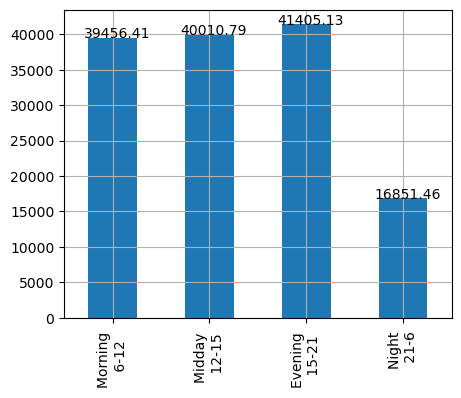

In [60]:
rmse_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(rmse_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))

plt.show()

In [61]:
mape_morning_scores= np.mean(np.abs(actual[morning_mask] -preds[morning_mask]) / actual[morning_mask]) * 100

mape_midday_scores= np.mean(np.abs(actual[midday_mask] -preds[midday_mask]) / actual[midday_mask]) * 100

mape_evening_scores= np.mean(np.abs(actual[evening_mask] -preds[evening_mask]) / actual[evening_mask]) * 100

mape_night_scores= np.mean(np.abs(actual[night_mask] -preds[night_mask]) / actual[night_mask]) * 100


mape_scores=pd.Series((mape_morning_scores,mape_midday_scores,mape_evening_scores, mape_night_scores))


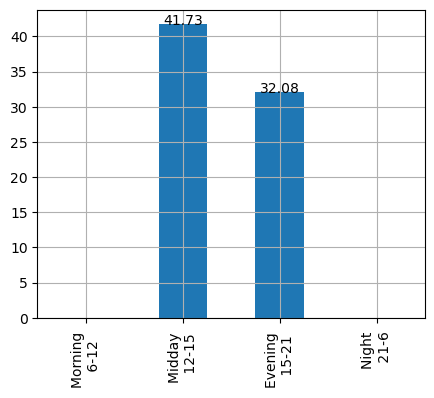

In [62]:
mape_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mape_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.2, v))

plt.show()

In [63]:
from sklearn.metrics import mean_absolute_error
mae_morning_scores = mean_absolute_error(actual[morning_mask], preds[morning_mask])
mae_midday_scores = mean_absolute_error(actual[midday_mask], preds[midday_mask])
mae_evening_scores = mean_absolute_error(actual[evening_mask], preds[evening_mask])
mae_night_scores = mean_absolute_error(actual[night_mask], preds[night_mask])

mae_scores = pd.Series((mae_morning_scores, mae_midday_scores, mae_evening_scores, mae_night_scores))


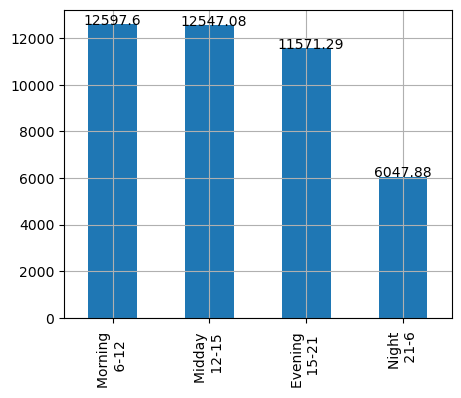

In [64]:
mae_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mae_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))

plt.show()

MAPE: 25.28%
RMSE: 21456.21
MAE: 11705.38
RSS: 994397149797


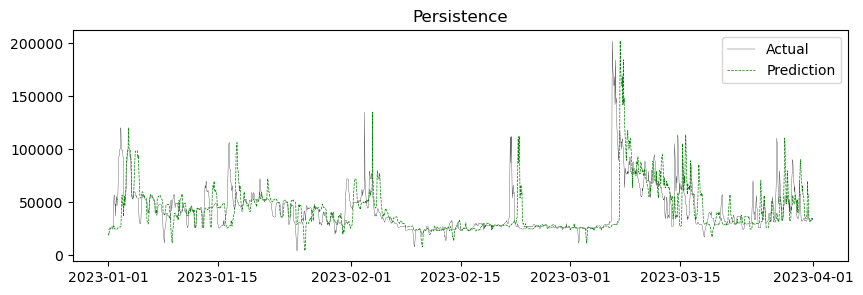

In [65]:
train_set = data[:365*24*3]
test_set = data[365*24*3:]

# calculate metrics
mape = np.mean(np.abs((test_set['TromsÃ¸'].values - test_set['Pred'].values) / test_set['TromsÃ¸'].values)) * 100
rmse = np.sqrt(mean_squared_error(test_set['TromsÃ¸'].values, test_set['Pred'].values))
mae= mean_absolute_error(test_set['TromsÃ¸'].values, test_set['Pred'].values)

# compute the residuals
residuals = test_set['TromsÃ¸'].values- test_set['Pred'].values

# compute the RSS
rss = np.sum(residuals**2)

print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'RSS: {rss:.0f}')

# plot the actual and predicted testues
plt.figure(figsize=(10, 3))
plt.plot(test_set.index.values, test_set['TromsÃ¸'].values, label='Actual', linewidth=0.2, c='black')
plt.plot(test_set.index.values, test_set['Pred'].values, label='Prediction', linewidth=0.5, linestyle='--', c='g')
plt.title('Persistence')
plt.legend()
plt.show()


In [66]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/markuswiikjensen/Desktop/Master-Data/Final_data/elspot_prices_dt_interpolated.csv')
df.drop(df.loc[df['datetime'].duplicated()].index, inplace = True)
df['datetime'] = pd.to_datetime(df['datetime'])

# df = df.sort_values(df['datetime'], ascending=[True])

last_date = df['datetime'] < '2023-04-01 00:00:00'
df = df[last_date]
df.set_index(df['datetime'], inplace = True)
df.drop(columns = [ 'datetime','Unnamed: 0'], inplace = True)
df

,Oslo,Kr.sand,Bergen,Molde,Tr.heim,TromsÃ¸
datetime,,,,,,
2020-01-01 00:00:00,31386.0,31386.0,31386.0,28387.0,28387.0,28387.0
2020-01-01 01:00:00,31336.0,31336.0,31336.0,28062.0,28062.0,28062.0
2020-01-01 02:00:00,31139.0,31139.0,31139.0,27519.0,27519.0,27519.0
2020-01-01 03:00:00,30853.0,30853.0,30853.0,27144.0,27144.0,27144.0
2020-01-01 04:00:00,30301.0,30301.0,30301.0,27164.0,27164.0,27164.0
...,...,...,...,...,...,...
2023-03-31 19:00:00,118638.0,118638.0,118638.0,74475.0,74475.0,35008.0
2023-03-31 20:00:00,115541.0,115541.0,115541.0,74520.0,74520.0,35008.0
2023-03-31 21:00:00,108281.0,108281.0,108281.0,75882.0,75882.0,35008.0


In [67]:
from sklearn.metrics import mean_squared_error

In [68]:
df1=df['Bergen']
df2=pd.DataFrame()
df2['Pred']=df['Bergen'].shift(24).copy()
data=pd.concat((df1,df2), axis= 1)


In [69]:
data=data.dropna(0)


/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_42548/1309451091.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  data=data.dropna(0)


In [70]:
data

,Bergen,Pred
datetime,,
2020-01-02 00:00:00,30235.0,31386.0
2020-01-02 01:00:00,30097.0,31336.0
2020-01-02 02:00:00,29891.0,31139.0
2020-01-02 03:00:00,29311.0,30853.0
2020-01-02 04:00:00,29370.0,30301.0
...,...,...
2023-03-31 19:00:00,118638.0,116558.0
2023-03-31 20:00:00,115541.0,124299.0
2023-03-31 21:00:00,108281.0,115610.0


MAPE: 80.67%
RMSE: 49520.92
MAE: 28290.96
RSS: 21482337285449


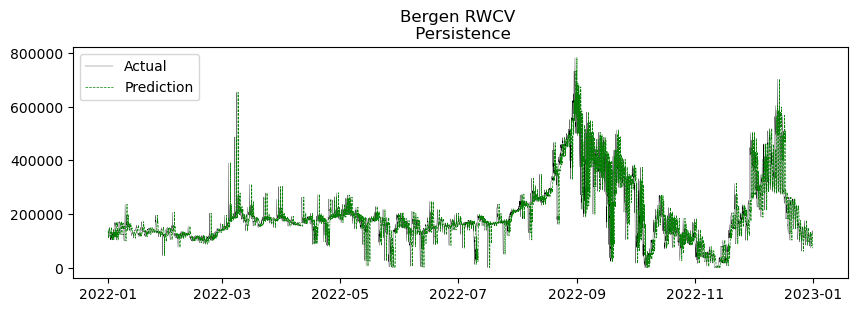

In [73]:
train_set = data[:365*24*2]
val_set = data[365*24*2:365*24*3]


# calculate metrics
mape = np.mean(np.abs((val_set['Bergen'].values - val_set['Pred'].values) / val_set['Bergen'].values)) * 100
rmse = np.sqrt(mean_squared_error(val_set['Bergen'].values, val_set['Pred'].values))
mae= mean_absolute_error(val_set['Bergen'].values, val_set['Pred'].values)

# compute the residuals
residuals = val_set['Bergen'].values- val_set['Pred'].values

# compute the RSS
rss = np.sum(residuals**2)

print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'RSS: {rss:.0f}')

# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(val_set.index.values, val_set['Bergen'].values, label='Actual', linewidth=0.2,  c='black')
plt.plot(val_set.index.values, val_set['Pred'].values, label='Prediction', linewidth=0.5, linestyle='--', c='g')
plt.title('Bergen RWCV \n Persistence')
plt.legend()
plt.show()


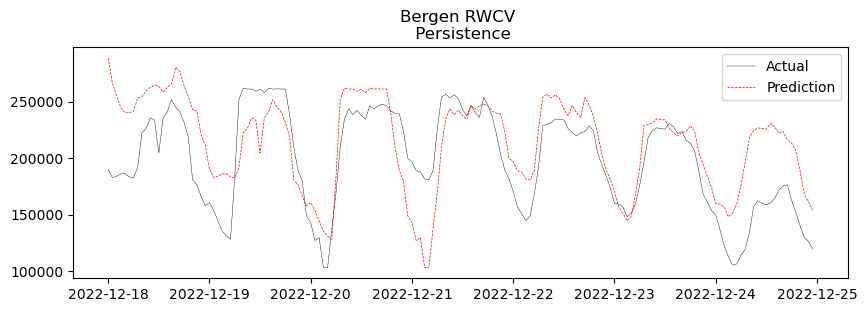

In [74]:
# Define x-axis values
x_pred = np.arange(8760)
x_actual = np.arange(26280)


# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(val_set.index[-24*14:-24*7].values, val_set['Bergen'][-24*14:-24*7].values, label='Actual', linewidth=0.3,  c='black')
plt.plot(val_set.index[-24*14:-24*7].values, val_set['Pred'][-24*14:-24*7].values, label='Prediction', linewidth=0.5, linestyle='--', c='r')
plt.title('Bergen RWCV \n Persistence')
plt.legend()
plt.show()



In [75]:
morning_mask = (val_set.iloc[-365*24:].index.hour >= 6) & (val_set.iloc[-365*24:].index.hour < 12)
midday_mask = (val_set.iloc[-365*24:].index.hour >= 12) & (val_set.iloc[-365*24:].index.hour < 15)
evening_mask = (val_set.iloc[-365*24:].index.hour >= 15) & (val_set.iloc[-365*24:].index.hour < 21)
night_mask = (val_set.iloc[-365*24:].index.hour >= 21) | (val_set.iloc[-365*24:].index.hour < 6)

preds=pd.Series(val_set['Pred'].values, index=val_set.index.values)
actual= pd.Series(val_set['Bergen'].values, index=val_set.index.values)

rmse_morning_scores= np.sqrt(mean_squared_error(actual[morning_mask], preds[morning_mask]))
rmse_morning_scores

rmse_midday_scores= np.sqrt(mean_squared_error(actual[midday_mask], preds[midday_mask]))
rmse_midday_scores

rmse_evening_scores= np.sqrt(mean_squared_error(actual[evening_mask], preds[evening_mask]))
rmse_evening_scores

rmse_night_scores= np.sqrt(mean_squared_error(actual[night_mask], preds[night_mask]))
rmse_night_scores

rmse_scores=pd.Series((rmse_morning_scores,rmse_midday_scores,rmse_evening_scores, rmse_night_scores))


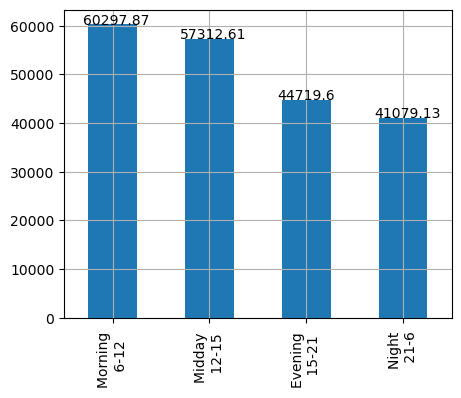

In [76]:
rmse_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(rmse_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))

plt.show()

In [77]:
mape_morning_scores= np.mean(np.abs(actual[morning_mask] -preds[morning_mask]) / actual[morning_mask]) * 100

mape_midday_scores= np.mean(np.abs(actual[midday_mask] -preds[midday_mask]) / actual[midday_mask]) * 100

mape_evening_scores= np.mean(np.abs(actual[evening_mask] -preds[evening_mask]) / actual[evening_mask]) * 100

mape_night_scores= np.mean(np.abs(actual[night_mask] -preds[night_mask]) / actual[night_mask]) * 100


mape_scores=pd.Series((mape_morning_scores,mape_midday_scores,mape_evening_scores, mape_night_scores))


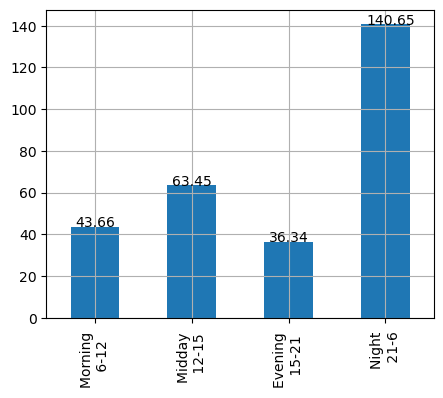

In [78]:
mape_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mape_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.2, v))

plt.show()

In [79]:
from sklearn.metrics import mean_absolute_error
mae_morning_scores = mean_absolute_error(actual[morning_mask], preds[morning_mask])
mae_midday_scores = mean_absolute_error(actual[midday_mask], preds[midday_mask])
mae_evening_scores = mean_absolute_error(actual[evening_mask], preds[evening_mask])
mae_night_scores = mean_absolute_error(actual[night_mask], preds[night_mask])

mae_scores = pd.Series((mae_morning_scores, mae_midday_scores, mae_evening_scores, mae_night_scores))


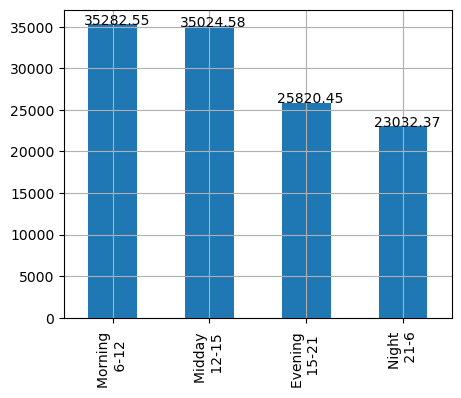

In [80]:
mae_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mae_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))

plt.show()

MAPE: 15.75%
RMSE: 25240.65
MAE: 16953.12
RSS: 1376115746374


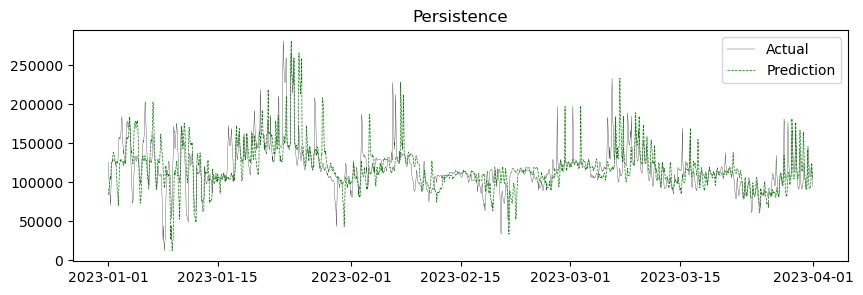

In [81]:
train_set = data[:365*24*3]
test_set = data[365*24*3:]

# calculate metrics
mape = np.mean(np.abs((test_set['Bergen'].values - test_set['Pred'].values) / test_set['Bergen'].values)) * 100
rmse = np.sqrt(mean_squared_error(test_set['Bergen'].values, test_set['Pred'].values))
mae= mean_absolute_error(test_set['Bergen'].values, test_set['Pred'].values)

# compute the residuals
residuals = test_set['Bergen'].values- test_set['Pred'].values

# compute the RSS
rss = np.sum(residuals**2)

print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'RSS: {rss:.0f}')


# plot the actual and predicted testues
plt.figure(figsize=(10, 3))
plt.plot(test_set.index.values, test_set['Bergen'].values, label='Actual', linewidth=0.2, c='black')
plt.plot(test_set.index.values, test_set['Pred'].values, label='Prediction', linewidth=0.5, linestyle='--', c='g')
plt.title('Persistence')
plt.legend()
plt.show()


In [82]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/markuswiikjensen/Desktop/Master-Data/Final_data/elspot_prices_dt_interpolated.csv')
df.drop(df.loc[df['datetime'].duplicated()].index, inplace = True)
df['datetime'] = pd.to_datetime(df['datetime'])

# df = df.sort_values(df['datetime'], ascending=[True])

last_date = df['datetime'] < '2023-04-01 00:00:00'
df = df[last_date]
df.set_index(df['datetime'], inplace = True)
df.drop(columns = [ 'datetime','Unnamed: 0'], inplace = True)
df

,Oslo,Kr.sand,Bergen,Molde,Tr.heim,TromsÃ¸
datetime,,,,,,
2020-01-01 00:00:00,31386.0,31386.0,31386.0,28387.0,28387.0,28387.0
2020-01-01 01:00:00,31336.0,31336.0,31336.0,28062.0,28062.0,28062.0
2020-01-01 02:00:00,31139.0,31139.0,31139.0,27519.0,27519.0,27519.0
2020-01-01 03:00:00,30853.0,30853.0,30853.0,27144.0,27144.0,27144.0
2020-01-01 04:00:00,30301.0,30301.0,30301.0,27164.0,27164.0,27164.0
...,...,...,...,...,...,...
2023-03-31 19:00:00,118638.0,118638.0,118638.0,74475.0,74475.0,35008.0
2023-03-31 20:00:00,115541.0,115541.0,115541.0,74520.0,74520.0,35008.0
2023-03-31 21:00:00,108281.0,108281.0,108281.0,75882.0,75882.0,35008.0


In [83]:
from sklearn.metrics import mean_squared_error

In [84]:
df1=df['Tr.heim']
df2=pd.DataFrame()
df2['Pred']=df['Tr.heim'].shift(24).copy()
data=pd.concat((df1,df2), axis= 1)


In [85]:
data=data.dropna(0)


/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_42548/1309451091.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  data=data.dropna(0)


In [86]:
data

,Tr.heim,Pred
datetime,,
2020-01-02 00:00:00,11856.0,28387.0
2020-01-02 01:00:00,12897.0,28062.0
2020-01-02 02:00:00,18732.0,27519.0
2020-01-02 03:00:00,20746.0,27144.0
2020-01-02 04:00:00,23860.0,27164.0
...,...,...
2023-03-31 19:00:00,74475.0,55870.0
2023-03-31 20:00:00,74520.0,55192.0
2023-03-31 21:00:00,75882.0,54267.0


MAPE: inf%
RMSE: 44054.50
MAE: 17969.56
RSS: 17001401587769


/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_42548/1638685709.py:5: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((val_set['Tr.heim'].values - val_set['Pred'].values) / val_set['Tr.heim'].values)) * 100


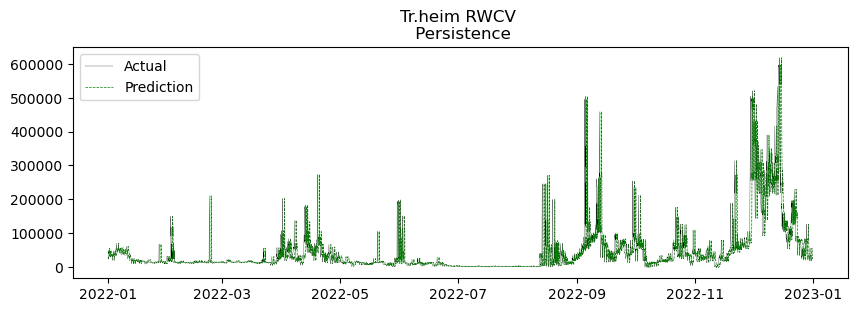

In [88]:
train_set = data[:365*24*2]
val_set = data[365*24*2:365*24*3]

# calculate metrics
mape = np.mean(np.abs((val_set['Tr.heim'].values - val_set['Pred'].values) / val_set['Tr.heim'].values)) * 100
rmse = np.sqrt(mean_squared_error(val_set['Tr.heim'].values, val_set['Pred'].values))
mae= mean_absolute_error(val_set['Tr.heim'].values, val_set['Pred'].values)

# compute the residuals
residuals = val_set['Tr.heim'].values- val_set['Pred'].values

# compute the RSS
rss = np.sum(residuals**2)

print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'RSS: {rss:.0f}')
# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(val_set.index.values, val_set['Tr.heim'].values, label='Actual', linewidth=0.2,  c='black')
plt.plot(val_set.index.values, val_set['Pred'].values, label='Prediction', linewidth=0.5, linestyle='--', c='g')
plt.title('Tr.heim RWCV \n Persistence')
plt.legend()
plt.show()


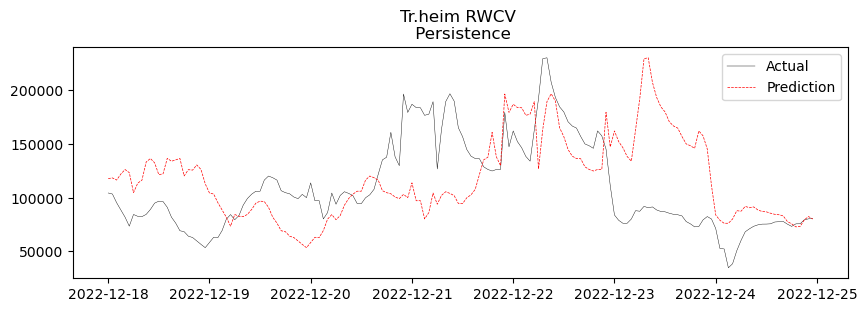

In [89]:
# Define x-axis values
x_pred = np.arange(8760)
x_actual = np.arange(26280)


# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(val_set.index[-24*14:-24*7].values, val_set['Tr.heim'][-24*14:-24*7].values, label='Actual', linewidth=0.3,  c='black')
plt.plot(val_set.index[-24*14:-24*7].values, val_set['Pred'][-24*14:-24*7].values, label='Prediction', linewidth=0.5, linestyle='--', c='r')
plt.title('Tr.heim RWCV \n Persistence')
plt.legend()
plt.show()



In [90]:
morning_mask = (val_set.iloc[-365*24:].index.hour >= 6) & (val_set.iloc[-365*24:].index.hour < 12)
midday_mask = (val_set.iloc[-365*24:].index.hour >= 12) & (val_set.iloc[-365*24:].index.hour < 15)
evening_mask = (val_set.iloc[-365*24:].index.hour >= 15) & (val_set.iloc[-365*24:].index.hour < 21)
night_mask = (val_set.iloc[-365*24:].index.hour >= 21) | (val_set.iloc[-365*24:].index.hour < 6)

preds=pd.Series(val_set['Pred'].values, index=val_set.index.values)
actual= pd.Series(val_set['Tr.heim'].values, index=val_set.index.values)

rmse_morning_scores= np.sqrt(mean_squared_error(actual[morning_mask], preds[morning_mask]))
rmse_morning_scores

rmse_midday_scores= np.sqrt(mean_squared_error(actual[midday_mask], preds[midday_mask]))
rmse_midday_scores

rmse_evening_scores= np.sqrt(mean_squared_error(actual[evening_mask], preds[evening_mask]))
rmse_evening_scores

rmse_night_scores= np.sqrt(mean_squared_error(actual[night_mask], preds[night_mask]))
rmse_night_scores

rmse_scores=pd.Series((rmse_morning_scores,rmse_midday_scores,rmse_evening_scores, rmse_night_scores))


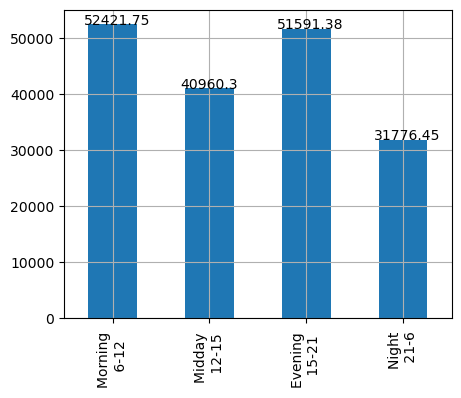

In [91]:
rmse_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(rmse_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))

plt.show()

In [92]:
mape_morning_scores= np.mean(np.abs(actual[morning_mask] -preds[morning_mask]) / actual[morning_mask]) * 100

mape_midday_scores= np.mean(np.abs(actual[midday_mask] -preds[midday_mask]) / actual[midday_mask]) * 100

mape_evening_scores= np.mean(np.abs(actual[evening_mask] -preds[evening_mask]) / actual[evening_mask]) * 100

mape_night_scores= np.mean(np.abs(actual[night_mask] -preds[night_mask]) / actual[night_mask]) * 100


mape_scores=pd.Series((mape_morning_scores,mape_midday_scores,mape_evening_scores, mape_night_scores))


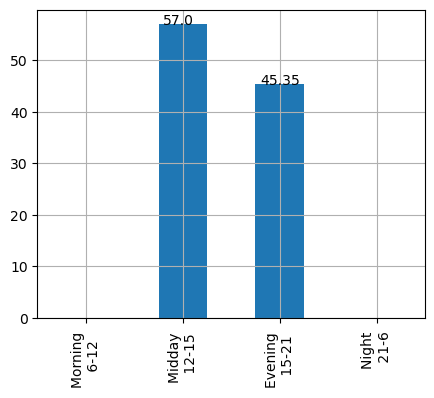

In [93]:
mape_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mape_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.2, v))

plt.show()

In [94]:
from sklearn.metrics import mean_absolute_error
mae_morning_scores = mean_absolute_error(actual[morning_mask], preds[morning_mask])
mae_midday_scores = mean_absolute_error(actual[midday_mask], preds[midday_mask])
mae_evening_scores = mean_absolute_error(actual[evening_mask], preds[evening_mask])
mae_night_scores = mean_absolute_error(actual[night_mask], preds[night_mask])

mae_scores = pd.Series((mae_morning_scores, mae_midday_scores, mae_evening_scores, mae_night_scores))


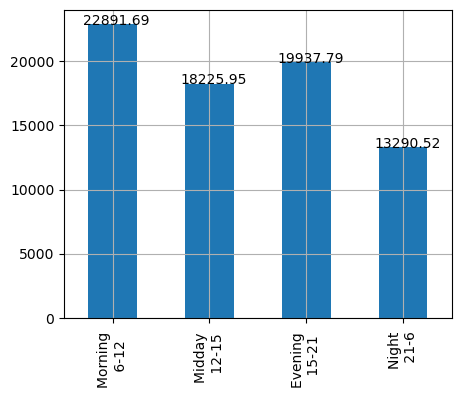

In [95]:
mae_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mae_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))

plt.show()

MAPE: 37.58%
RMSE: 30448.73
MAE: 21069.22
RSS: 2002589934553


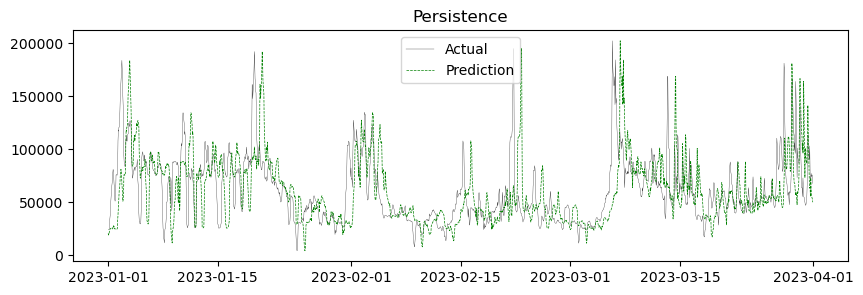

In [96]:
train_set = data[:365*24*3]
test_set = data[365*24*3:]

# calculate metrics
mape = np.mean(np.abs((test_set['Tr.heim'].values - test_set['Pred'].values) / test_set['Tr.heim'].values)) * 100
rmse = np.sqrt(mean_squared_error(test_set['Tr.heim'].values, test_set['Pred'].values))
mae= mean_absolute_error(test_set['Tr.heim'].values, test_set['Pred'].values)

# compute the residuals
residuals =test_set['Tr.heim'].values- test_set['Pred'].values

# compute the RSS
rss = np.sum(residuals**2)

print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'RSS: {rss:.0f}')

# plot the actual and predicted testues
plt.figure(figsize=(10, 3))
plt.plot(test_set.index.values, test_set['Tr.heim'].values, label='Actual', linewidth=0.2, c='black')
plt.plot(test_set.index.values, test_set['Pred'].values, label='Prediction', linewidth=0.5, linestyle='--', c='g')
plt.title('Persistence')
plt.legend()
plt.show()
